# BERT4Rec

이번 실습에서는 BERT4Rec(Sun et al, https://arxiv.org/abs/1904.06690) 을 이해하고 구현해보겠습니다.
BERT4Rec은 자연어 처리의 word embedding 학습에 많이 사용되는 BERT를 sequential recommendation에 적용한 모델입니다.
BERT는 최근 자연어 처리 뿐만 아니라 영상 처리 분야의 self-supervised learning에서도 사용되는 모델입니다. BERT의 소개 논문을 읽어보시기를 추천드립니다. (https://arxiv.org/abs/1810.04805)

이번 실습을 통해서 sequential recommendation에서 어떻게 BERT를 사용하였는지 살펴보겠습니다.

(참고 코드: https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch)

## Model overview

먼저 BERT4Rec의 overview를 살펴보겠습니다. BERT4Rec은 자연어 처리의 word embedding에 많이 사용하는 BERT를 sequential recommendation에 적용한 모델입니다. BERT는 Transformer와 마찬가지로 self-attention에 기반을 둔 모델입니다. BERT와 Transformer의 차이점은 cloze task를 사용한 학습 방법과 bidirectional 정보를 사용한다는 것입니다. (자연어 처리 분야에서는 cloze task 외에 다른 task를 학습에 적용하기도 합니다.) 

BERT4Rec에서는 기존 BERT의 학습 방법을 사용하였습니다. 강의에서 이미 학습한 것과 같이 BERT는 다음 item을 예측하기 보다는 주변 context를 파악하는 cloze task를 통해 학습합니다. 거의 대부분의 component가 SASRec과 같지만 학습 방법과 세부적인 차이에 대해 본 예제를 통해 살펴봅시다.

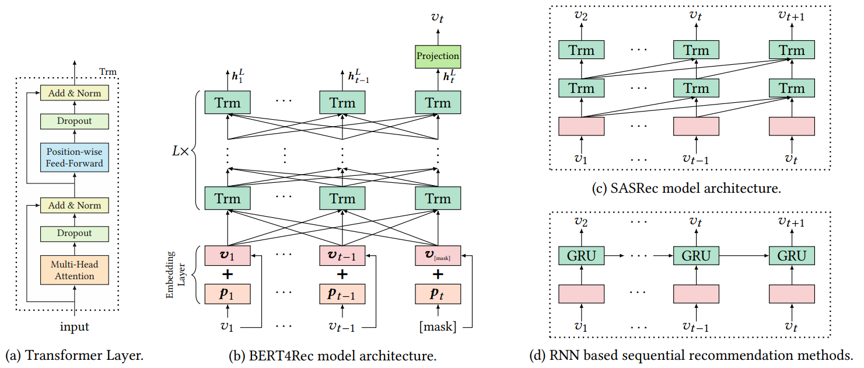

## Modules

In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Hyper-parameters

In [2]:
# model setting
max_len = 50
hidden_units = 50
num_heads = 1
num_layers = 2
dropout_rate=0.5
num_workers = 1
device = 'cuda' 

# training setting
lr = 0.001
batch_size = 128
num_epochs = 200
mask_prob = 0.15 # for cloze task

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [3]:
# !wget <대회 데이터 URL>
# !tar -xf data.tar.gz

## Data preprocessing

Data preprocessing은 SASRec과 달리 cloze task 수행을 위한 masking을 추가해주어야 합니다. 그 외의 부분은 SASRec과 유사합니다. Masking이 추가 되었다는 것에 주의하여 Data preprocessing을 구현해봅시다.

In [5]:
############# 중요 #############
# data_path는 사용자의 디렉토리에 맞게 설정해야 합니다.
data_path = "/opt/ml/input/data/train/train_ratings.csv"
df = pd.read_csv(data_path)

item_ids = df['item'].unique()
user_ids = df['user'].unique()
num_item, num_user = len(item_ids), len(user_ids)
num_batch = num_user // batch_size

# user, item indexing
item2idx = pd.Series(data=np.arange(len(item_ids))+1, index=item_ids) # item re-indexing (1~num_item), num_item+1: mask idx
user2idx = pd.Series(data=np.arange(len(user_ids)), index=user_ids) # user re-indexing (0~num_user-1)

# dataframe indexing
df = pd.merge(df, pd.DataFrame({'item': item_ids, 'item_idx': item2idx[item_ids].values}), on='item', how='inner')
df = pd.merge(df, pd.DataFrame({'user': user_ids, 'user_idx': user2idx[user_ids].values}), on='user', how='inner')
df.sort_values(['user_idx', 'time'], inplace=True)
del df['item'], df['user'] 

# train set, valid set 생성
users = defaultdict(list) # defaultdict은 dictionary의 key가 없을때 default 값을 value로 반환
user_train = {}
user_valid = {}
for u, i, t in zip(df['user_idx'], df['item_idx'], df['time']):
    users[u].append(i)

for user in users:
    user_train[user] = users[user][:-1]
    user_valid[user] = [users[user][-1]]

print(f'num users: {num_user}, num items: {num_item}')

num users: 31360, num items: 6807


SASRec에서는 sample function을 따로 구현했지만, BERT4Rec에서는 pytorch의 내장 data loader를 사용하여서 구현해봅시다. Custom dataset을 구현하기 위해서는 pytorch의 dataset class를 상속받아 생성한 class의 구현이 필요합니다. 자세한 문법은 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 에서 확인할 수 있습니다.

In [6]:
class SeqDataset(Dataset):
    def __init__(self, user_train, num_user, num_item, max_len, mask_prob):
        self.user_train = user_train
        self.num_user = num_user
        self.num_item = num_item
        self.max_len = max_len
        self.mask_prob = mask_prob

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        # iterator를 구동할 때 사용됩니다.
        seq = self.user_train[user]
        tokens = []
        labels = []
        for s in seq:
            prob = np.random.random() # TODO1: numpy를 사용해서 0~1 사이의 임의의 값을 샘플링하세요.
            if prob < self.mask_prob:
                prob /= self.mask_prob

                # BERT 학습
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.9:
                    tokens.append(np.random.randint(1, self.num_item+1))  # item random sampling
                else:
                    tokens.append(s)
                labels.append(s)  # 학습에 사용
            else:
                tokens.append(s)
                labels.append(0)  # 학습에 사용 X, trivial
        tokens = tokens[-self.max_len:]
        labels = labels[-self.max_len:]
        mask_len = self.max_len - len(tokens)

        # zero padding
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels
        return torch.LongTensor(tokens), torch.LongTensor(labels)

## Model

Multi-head attention 부분은 SASRec과 같습니다. 다만 point-wise feed forward network에서 GeLU activation을 사용한다는 차이점이 있습니다. 그리고 point-wise feed forward network의 MLP의 dimension을 SASRec에서는 일정하게 유지시켰지만 BERT4Rec에서는 NLP에서 사용하는 모델과 같이 dimension에 4배 차이를 두었습니다. Positional encoding 역시 SASRec과 마찬가지로 학습 가능하도록 모델링합니다. 

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate) # dropout rate

    def forward(self, Q, K, V, mask):
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units, bias=False)
        self.W_O = nn.Linear(hidden_units, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate) # scaled dot product attention module을 사용하여 attention 계산
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)
        
        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) 
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        output, attn_dist = self.attention(Q, K, V, mask)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() 
        output = output.view(batch_size, seqlen, -1)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual)
        return output, attn_dist
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()
        
        # SASRec과의 dimension 차이가 있습니다.
        self.W_1 = nn.Linear(hidden_units, 4 * hidden_units) 
        self.W_2 = nn.Linear(4 * hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.gelu(self.dropout(self.W_1(x)))) # activation: relu -> gelu
        output = self.layerNorm(self.dropout(output) + residual)
        return output
    
class BERT4RecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(BERT4RecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist

### BERT4Rec

위에서 구현한 class를 가지고 BERT4Rec을 구현해봅시다. BERT4Rec의 item embedding은 item의 개수에 비해 2개 더 많게 설정해야 합니다. 이는 padding과 cloze task를 위한 mask를 표기하기 위함입니다. 최종적으로 다음 item을 예측할 때도 전체 log에 mask index를 추가하여 예측을 수행합니다.

In [8]:
class BERT4Rec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(BERT4Rec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 2, hidden_units, padding_idx=0) # TODO2: mask와 padding을 고려하여 embedding을 생성해보세요.
        self.pos_emb = nn.Embedding(max_len, hidden_units) # learnable positional encoding
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([BERT4RecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        self.out = nn.Linear(hidden_units, num_item + 1) # TODO3: 예측을 위한 output layer를 구현해보세요. (num_item 주의)
        
    def forward(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device))
        positions = np.tile(np.array(range(log_seqs.shape[1])), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.device))
        seqs = self.emb_layernorm(self.dropout(seqs))

        mask = torch.BoolTensor(log_seqs > 0).unsqueeze(1).repeat(1, log_seqs.shape[1], 1).unsqueeze(1).to(self.device) # mask for zero pad
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask)
        out = self.out(seqs)
        return out

## Training

In [9]:
model = BERT4Rec(num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0) # label이 0인 경우 무시
seq_dataset = SeqDataset(user_train, num_user, num_item, max_len, mask_prob)
data_loader = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, pin_memory=True) # TODO4: pytorch의 DataLoader와 seq_dataset을 사용하여 학습 파이프라인을 구현해보세요.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
for epoch in range(1, num_epochs + 1):
    tbar = tqdm(data_loader)
    for step, (log_seqs, labels) in enumerate(tbar):
        logits = model(log_seqs)
        
        # size matching
        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1).to(device)
        
        optimizer.zero_grad()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        tbar.set_description(f'Epoch: {epoch:3d}| Step: {step:3d}| Train loss: {loss:.5f}')

Epoch:   1| Step: 244| Train loss: 7.61974: 100%|██████████| 245/245 [00:08<00:00, 27.47it/s]
Epoch:   2| Step: 244| Train loss: 7.46940: 100%|██████████| 245/245 [00:08<00:00, 27.34it/s]
Epoch:   3| Step: 244| Train loss: 7.59558: 100%|██████████| 245/245 [00:08<00:00, 28.53it/s]
Epoch:   4| Step: 244| Train loss: 7.48222: 100%|██████████| 245/245 [00:08<00:00, 29.25it/s]
Epoch:   5| Step: 244| Train loss: 7.62293: 100%|██████████| 245/245 [00:08<00:00, 28.08it/s]
Epoch:   6| Step: 244| Train loss: 7.52655: 100%|██████████| 245/245 [00:08<00:00, 27.80it/s]
Epoch:   7| Step: 244| Train loss: 7.56626: 100%|██████████| 245/245 [00:08<00:00, 29.18it/s]
Epoch:   8| Step: 244| Train loss: 7.42014: 100%|██████████| 245/245 [00:08<00:00, 27.23it/s]
Epoch:   9| Step: 244| Train loss: 7.34115: 100%|██████████| 245/245 [00:08<00:00, 27.63it/s]
Epoch:  10| Step: 244| Train loss: 7.33681: 100%|██████████| 245/245 [00:08<00:00, 28.55it/s]
Epoch:  11| Step: 244| Train loss: 7.33884: 100%|██████████|

### Evaluation

In [11]:
def random_neg(l, r, s):
    # log에 존재하는 아이템과 겹치지 않도록 sampling
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t

model.eval()

NDCG = 0.0 # NDCG@10
HIT = 0.0 # HIT@10

num_item_sample = 100
num_user_sample = 1000
users = np.random.randint(0, num_user, num_user_sample) # 1000개만 sampling 하여 evaluation
for u in users:
    seq = (user_train[u] + [num_item + 1])[-max_len:] # TODO5: 다음 아이템을 예측하기 위한 input token을 추가해주세요.
    rated = set(user_train[u] + user_valid[u])
    item_idx = [user_valid[u][0]] + [random_neg(1, num_item + 1, rated) for _ in range(num_item_sample)]

    with torch.no_grad():
        predictions = - model(np.array([seq]))
        predictions = predictions[0][-1][item_idx] # sampling
        rank = predictions.argsort().argsort()[0].item()
    
    if rank < 10: # @10
        NDCG += 1 / np.log2(rank + 2)
        HIT += 1
print(f'NDCG@10: {NDCG/num_user_sample}| HIT@10: {HIT/num_user_sample}')

NDCG@10: 0.4657214826794348| HIT@10: 0.733
